In [ ]:
# Get METAR data in bulk
%run auto_request_data.py

In [172]:
# Parse relevant METAR data into CSV
%run parse_to_csv.py RCTP

RCTP


In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [6]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

In [7]:
airport = "RCTP"

train_df = pd.read_csv(airport + "/" + airport + "_train.csv")
test_df = pd.read_csv(airport + "/" + airport + "_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

print(train_df)

       windSpdKts  gustKts  windVrbDeg  intensity  rain  visibilityMtrs   qnh  \
15354          20        0           0       0.00     0            9999  1002   
7554            5        0          60       0.00     0            9999  1010   
11190          19        0           0       0.00     0            9999  1024   
40023           3        0         170       0.00     0            9999  1021   
15560           3        0           0       0.00     0            9999  1009   
...           ...      ...         ...        ...   ...             ...   ...   
21085          14        0           0       0.00     0            4000  1019   
24231          23        0           0       0.00     0            9999  1015   
19051          17        0           0       0.30     1            9999  1015   
27848          22        0           0       0.00     0            9999  1001   
4527            6        0           0       0.00     0            9999  1019   

       ws  
15354   0  
755

In [8]:
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Scale down wind speed
train_df_norm["windSpdKts"] /= 50
test_df_norm["windSpdKts"] /= 50

# Scale down wind gust speed
train_df_norm["gustKts"] /= 50
test_df_norm["gustKts"] /= 50

# Scale down wind variability
train_df_norm["windVrbDeg"] /= 100
test_df_norm["windVrbDeg"] /= 100

# Scale down visibility
# train_df_norm["visibilityMtrs"] /= 10000
# test_df_norm["visibilityMtrs"] /= 10000

# Normalise, scale down QNH
train_df_norm["qnh"] -= 1013
train_df_norm["qnh"] /= 10
test_df_norm["qnh"] -= 1013
test_df_norm["qnh"] /= 10

print(train_df_norm)
print(test_df_norm)

       windSpdKts  gustKts  windVrbDeg  intensity  rain  visibilityMtrs   qnh  \
15354        0.40     0.00        0.00       0.00     0            9999 -1.10   
7554         0.10     0.00        0.60       0.00     0            9999 -0.30   
11190        0.38     0.00        0.00       0.00     0            9999  1.10   
40023        0.06     0.00        1.70       0.00     0            9999  0.80   
15560        0.06     0.00        0.00       0.00     0            9999 -0.40   
...           ...      ...         ...        ...   ...             ...   ...   
21085        0.28     0.00        0.00       0.00     0            4000  0.60   
24231        0.46     0.00        0.00       0.00     0            9999  0.20   
19051        0.34     0.00        0.00       0.30     1            9999  0.20   
27848        0.44     0.00        0.00       0.00     0            9999 -1.20   
4527         0.12     0.00        0.00       0.00     0            9999  0.60   

       ws  
15354   0  
755

In [9]:
feature_columns = []

windSpdKts = tf.feature_column.numeric_column("windSpdKts")
feature_columns.append(windSpdKts)

gustKts = tf.feature_column.numeric_column("gustKts")
feature_columns.append(gustKts)

windVrbDeg = tf.feature_column.numeric_column("windVrbDeg")
feature_columns.append(windVrbDeg)

intensity = tf.feature_column.numeric_column("intensity")
feature_columns.append(intensity)

rain = tf.feature_column.numeric_column("rain")
feature_columns.append(rain)

vis_boundaries = list(np.arange(-1, 10000, 1000))
visibilityMtrs = tf.feature_column.numeric_column("visibilityMtrs")
visibilityMtrsBin = tf.feature_column.bucketized_column(visibilityMtrs, vis_boundaries)
feature_columns.append(visibilityMtrsBin)
# print(visibilityMtrsBin)

qnh = tf.feature_column.numeric_column("qnh")
feature_columns.append(qnh)

# Create a feature cross of windSpdKts and windVrbDeg
spd_x_vrb = tf.feature_column.crossed_column(["windSpdKts", "windVrbDeg"], hash_bucket_size=1000)
crossed_spd_vrb = tf.feature_column.indicator_column(spd_x_vrb)
feature_columns.append(crossed_spd_vrb)

# Create a feature cross of intensity and rain
int_x_rain = tf.feature_column.crossed_column(["intensity", "rain"], hash_bucket_size=50)
crossed_int_rain = tf.feature_column.indicator_column(int_x_rain)
feature_columns.append(crossed_int_rain)

feature_layer = layers.DenseFeatures(feature_columns)

# np.set_printoptions(threshold=False)
# print(train_df_norm[train_df_norm.visibilityMtrs == train_df_norm.visibilityMtrs.min()])
# print(feature_layer(dict(train_df_norm)))

In [67]:
def neural_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a ReLU function.
    model.add(tf.keras.layers.Dense(units=40, activation='relu', name="hidden1",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units=20, activation='relu', name="hidden2",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1, name='Output', activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model


def linear_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(20,), activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model   


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, validation_split=0.2):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                          epochs=epochs, shuffle=shuffle, validation_split=validation_split)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist

print("Defined the 2 models and train_model functions.")

Defined the 2 models and train_model functions.


In [68]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""   

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [69]:
def get_initial_bias(train_set):
    pos_count = len(train_set[train_set.ws == 1])
    neg_count = train_set.size - pos_count
    return np.log([pos_count / neg_count])

Epoch 1/20
287/287 [==============================] - 2s 4ms/step - loss: 0.4060 - accuracy: 0.9009 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.5309 - pr-auc: 0.1409 - val_loss: 0.3015 - val_accuracy: 0.9040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.8008 - val_pr-auc: 0.3124
Epoch 2/20
287/287 [==============================] - 1s 2ms/step - loss: 0.2878 - accuracy: 0.9032 - precision: 0.8056 - recall: 0.0306 - roc-auc: 0.8303 - pr-auc: 0.3675 - val_loss: 0.2657 - val_accuracy: 0.9101 - val_precision: 0.7372 - val_recall: 0.0976 - val_roc-auc: 0.8576 - val_pr-auc: 0.4323
Epoch 3/20
287/287 [==============================] - 1s 2ms/step - loss: 0.2595 - accuracy: 0.9107 - precision: 0.7178 - recall: 0.1631 - roc-auc: 0.8706 - pr-auc: 0.4684 - val_loss: 0.2468 - val_accuracy: 0.9137 - val_precision: 0.6578 - val_recall: 0.2105 - val_roc-auc: 0.8784 - val_pr-auc: 0.4779
Epoch 4/20
287/287 [==============================] - 1s 2ms/step - loss: 0.24

103/103 [==============================] - 0s 1ms/step - loss: 0.2208 - accuracy: 0.9131 - precision: 0.5711 - recall: 0.5039 - roc-auc: 0.9099 - pr-auc: 0.5652
[0.22082923352718353, 0.9130688905715942, 0.5711110830307007, 0.5039215683937073, 0.9098989963531494, 0.5651687383651733]


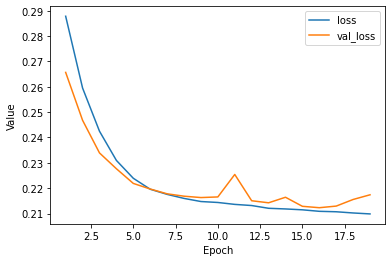

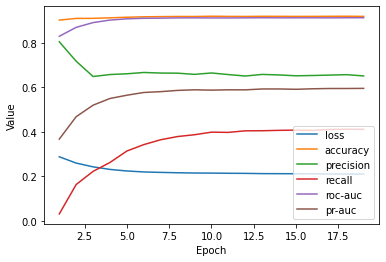

In [70]:
learning_rate = 0.0005
epochs = 20
batch_size = 100
label_name = "ws"
classification_threshold = 0.45
validation_split = 0.3
initial_bias = get_initial_bias(train_df_norm)

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),
    tf.keras.metrics.AUC(num_thresholds=100, name='roc-auc'),
    tf.keras.metrics.AUC(num_thresholds=100, name='pr-auc', curve='PR')
]

# Establish the model's topography.
my_model = neural_model(learning_rate, feature_layer, METRICS, initial_bias=initial_bias)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size, validation_split=validation_split)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot_1 = ['loss', 'val_loss']
list_of_metrics_to_plot_2 = ['loss', 'accuracy', 'precision', 'recall', 'roc-auc', 'pr-auc']

plot_curve(epochs, hist, list_of_metrics_to_plot_1)
plot_curve(epochs, hist, list_of_metrics_to_plot_2)

x_test = {name: np.array(value) for name, value in test_df_norm.items()}
y_test = np.array(x_test.pop(label_name))

results = my_model.evaluate(x_test, y_test, batch_size=batch_size)
print(results)